In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

In [17]:
data_path = 'data/arcade/syntax/val'
imgs_path = data_path + '/images'
annots_path = data_path + '/annotations'
imgs = sorted(os.listdir(imgs_path))
annots = json.load(open(annots_path + '/val.json'))['annotations']

In [18]:
annots[0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes'])

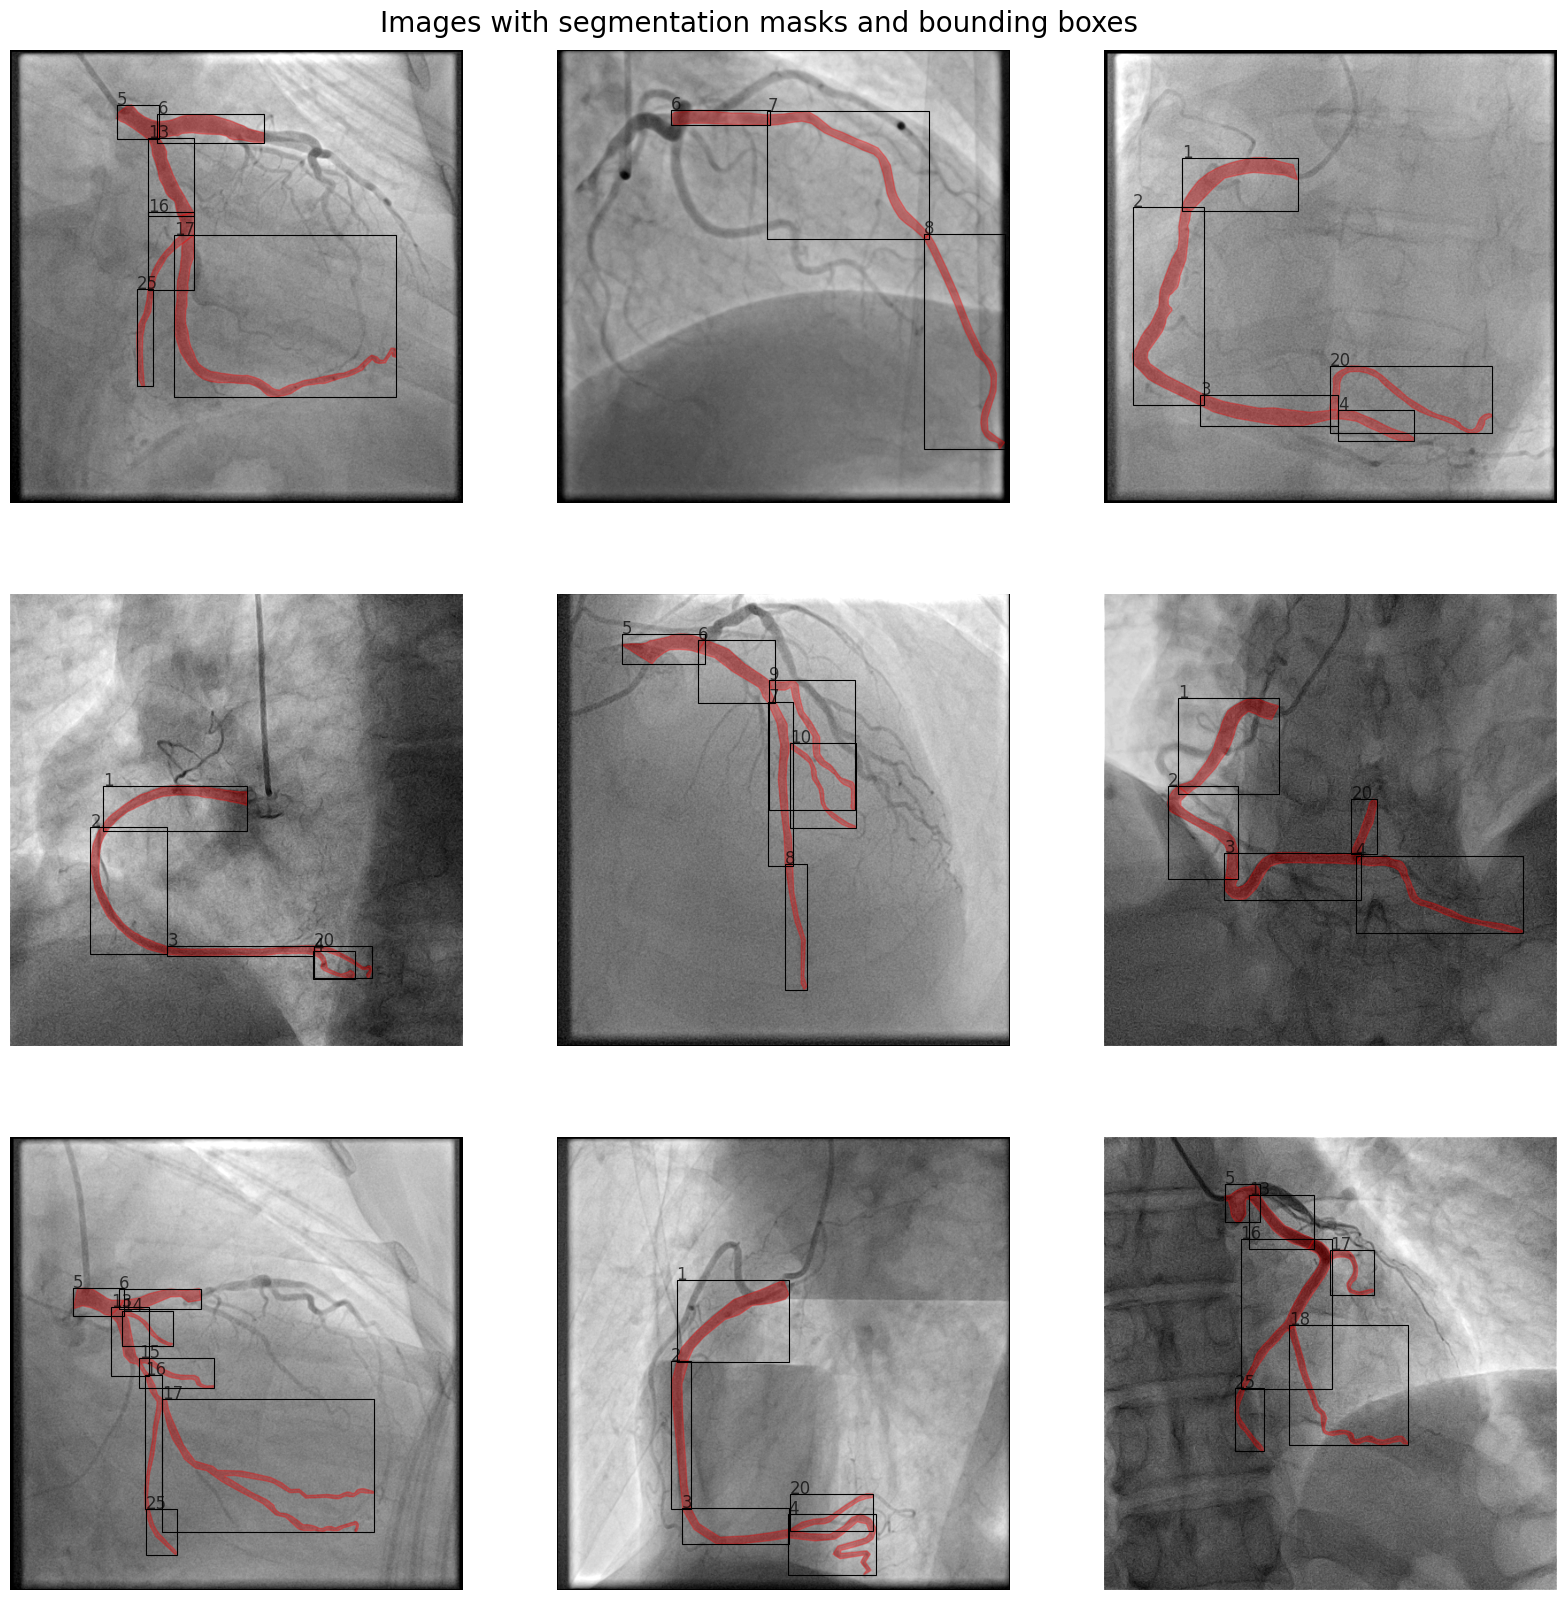

In [20]:
k = 3
plt.subplots(k, k, figsize=(20, 20))
plt.suptitle('Images with segmentation masks and bounding boxes', fontsize=20, y=0.9)
for i, img in enumerate(imgs[:k*k]):
    plt.subplot(k, k, i + 1)
    plt.imshow(plt.imread(imgs_path + '/' + img), cmap='gray')
    plt.axis('off')
    
    # Segmentation mask
    for j, annot in enumerate(annots):
        if annot['image_id'] == i + 1:
            for seg in annot['segmentation']:
                plt.fill(seg[0::2], seg[1::2], alpha=0.3, color='r')

    # Bounding boxes
    for j, annot in enumerate(annots):
        if annot['image_id'] == i + 1:
            x, y, w, h = annot['bbox']
            plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=0.8, facecolor='none', edgecolor='black'))
            plt.text(x, y, annot['category_id'], fontsize=12, alpha=0.7, color='black')
plt.show()